<a href="https://colab.research.google.com/github/RyanSchw/hackohio/blob/master/VineClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tweet Classification
Based on https://mc.ai/guide-to-text-classification-with-fastai/

In [0]:
import numpy as np 
import pandas as pd 
from pathlib import Path
from fastai.text import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path=Path('/content/gdrive/My Drive/hackohio')

In [0]:
df = pd.read_csv(path/'vines.csv')
df.columns = ['Vine_Energy', 'Quote']

Clean / lemmatize data

In [0]:
# Uncomment and download if necessary
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

In [110]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
def sanitize_string(s):
  # Remove punctuation
  s = s.replace(r'[^\w\s]+', '')

  # All lowercase
  s = s.lower()

  # Tokenize sentence (split up into words)
  s = word_tokenize(s)

  lemmatizer = WordNetLemmatizer()
  stop = stopwords.words('english')
  s = [lemmatizer.lemmatize(words) for words in s if words not in stop]

  return s

df['Quote'] = df['Quote'].apply(sanitize_string)

# Reduce the 1 Vine Energy so the distribution so that everything isn't so messed up
df = df[:-100]

# Reduce bucket size for vine energy
df['Vine_Energy'] = df['Vine_Energy'].div(4).apply(np.floor).add(1).astype('int')

0               [get, waffle, ?, please, get, waffle, ?]
1      [liam, neeson, ,, liam, neeson, 's, knee, son,...
2                    [die, either, kill, get, killed, .]
3                                       [yes, ,, see, .]
4                                    [siri, 's, name, .]
                             ...                        
572                  [change, thought, change, world, .]
573    [either, write, something, worth, reading, som...
574    [nothing, impossible, ,, word, say, ,, “, ’, p...
575                          [way, great, work, love, .]
576                               [dream, ,, achieve, .]
Name: Quote, Length: 577, dtype: object


Here's some fun facts about the data

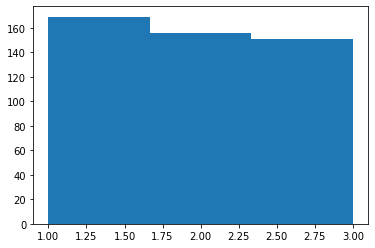

In [111]:
import matplotlib.pyplot as plt
# Find the frequency of each rating and graph
number_of_ratings = 3

plt.hist(df.loc[1:, 'Vine_Energy'], bins=number_of_ratings)
plt.show()

Split data into training/testing

In [0]:
validation_split = 8 / 10
df = df.iloc[np.random.permutation(len(df))]
cut1 = int(validation_split * len(df)) + 1
df_train, df_valid = df[:cut1], df[cut1:]
# df_train.columns = ['Vine_Energy', 'Quote']
# df_valid.columns = ['Vine_Energy', 'Quote']

Distribution of training data to validation data

Text(0.5, 1.0, 'Distribution of training data to validattion data based on score')

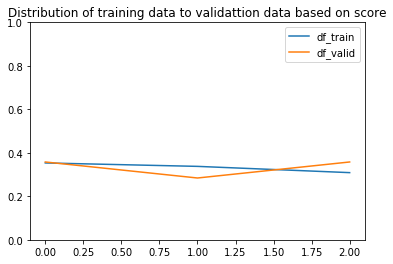

In [122]:
frequencies = [[0]*number_of_ratings, [0]*number_of_ratings]
for i, j in df_train.iterrows():
  frequencies[0][j['Vine_Energy']-1] += 1

for i, j in df_valid.iterrows():
  frequencies[1][j['Vine_Energy']-1] += 1


frequencies[0] = [x / sum(frequencies[0]) for x in frequencies[0]]
frequencies[1] = [x / sum(frequencies[1]) for x in frequencies[1]]
plt.plot(range(number_of_ratings), frequencies[0], label='df_train')
plt.plot(range(number_of_ratings), frequencies[1], label='df_valid')
plt.legend()
plt.ylim(0, 1)
plt.title('Distribution of training data to validattion data based on score')

In [0]:
data_lm = TextLMDataBunch.from_df(path=path,
 train_df=df_train,
 valid_df=df_valid, 
 label_cols='Vine_Energy',
 text_cols='Quote')

In [0]:
# data_lm.save(path, 'lm_databunch.pkl')
# data_lm.load('lm_databunch.pkl')

Create the language model

In [0]:
lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
lm.save_encoder(path/'fine-tuned_encoder.pth')

Create the classifier model

In [127]:
data_clas=TextClasDataBunch.from_df(path=path,train_df=df_train, valid_df=df_valid, vocab=data_lm.train_ds.vocab, label_cols='Vine_Energy', text_cols='Quote')
clas = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.3)
clas.load_encoder(path/'fine-tuned_encoder.pth')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (382 items)
x: TextList
xxbos [ ' better ' , ' watch ' , ' , ' , ' better ' , ' watch ' , ' , ' , ' better ' , ' watch ' , ' , ' , ' better ' , ' watch ' , ' , ' , ' better ' , ' watch ' , ' . ' ],xxbos [ ' stand ' , ' god ' , ' end ' , ' life ' , ' , ' , ' would ' , ' hope ' , ' would ' , ' xxunk ' , ' xxunk ' , ' xxunk ' , ' xxunk ' , ' could ' , ' say ' , ' , ' , ' xxunk ' , ' everything ' , ' gave ' , ' . ' ],xxbos [ ' know ' , ' , ' , " ' m " , ' say ' , ' , ' , " n't " , ' xxunk ' , ' xxunk ' , ' xxunk ' ],xxbos [ ' kid ' , ' want ' , ' blade ' , ' , ' , ' blade ' , ' xxunk ' , ' xxunk ' , ' kind ' , ' xxunk ' , ' . ' ],xxbos [ ' water ' , ' xxunk ' , ' day ' , ' crocs ' , ' . ' ]
y: CategoryList
3,1,3,1,1
Path: /content/gdrive/My Drive/hackohio;

Valid: LabelList (95 items)
x: TextList
xxbos [ ' two ' , ' xxunk ' , ' day ' , ' life ' , ' day ' , ' xxunk ' , ' day ' , ' xxunk ' , ' . ' ],xxbos [ ' anything ' , ' better ' , ' pu

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.45E-02


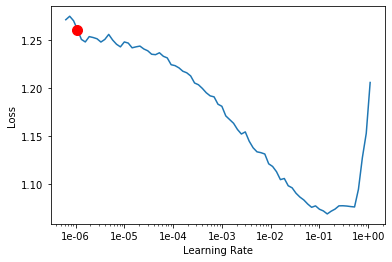

In [128]:
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [129]:
# Fit one cycle based on the plot
# clas.fit_one_cycle(1, 3.63e-02, moms=(0.8,0.7))
clas.fit_one_cycle(1, 1.45e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.308767,1.084773,0.442105,00:01


In [140]:
data = clas.predict(sanitize_string('ok boomer'))
data

(Category 3, tensor(2), tensor([0.2900, 0.2666, 0.4434]))

In [42]:
max(data[2]) - min(data[2])

tensor(0.0283)

In [0]:
clas.export(path/'vine_energy_pt2.pkl')